# ALOHAdielCurveFit: Jupyter Notebook for "unbiased" fitting of sinusoidal functions to some of the SCOPE diel data 
Created 12 Apr 2018 by Jamie Collins, james.r.collins@aya.yale.edu
Revision history in GitHub

Some of this code inspired by MATLAB scripts developed for Modeling, Data Analysis and Numerical Techniques for Geochemistry (12.747), a course at MIT

Dependencies: scipy.optimize, numpy, some others

## Summary of approach; pros and cons

1. Objectives:
    1. Fit some very simple, fully intepretable models to the SCOPE diel data
    2. Obtain estimates of daily minima and maxima in the concentrations of various metabolites, assuming that:
        1. The observed minima/maxima don't necessarily reflect the true minima/maxima
            1. Our sampling frequency low enough that the scheme wasn't likely sufficient to capture the true range of values
        1. The minimum and/or maximum on a given day might be very different than the minimum/maximum on preceding or subsequent days 
1. Constraints:
    1. We would like to use some sort of traditional signal processing (e.g., FFT) for this purpose, but the short length, sparsity, and variance (i.e., wide spread between replicates) of the metabolite data are such that this would be impossible/impractical
        1. We could certainly use FFT to analyze the SeaFlow data, but the nature of FFT would prevent us from capturing the frequencies of interest we are assuming are present in the metabolite data
        1. An FFT approach also wouldn't produce the curve fits we are seeking to diagnose daily differences in minima, maxima, period, and amplitude
        1. Because of our arbitrary sampling timepoints and samping interval, we don't know where the true minima and maxima are
1. Desirables:
    1. Intepretability of all parameters
    1. Some sort of hypothesis testing for each parameter (two-tailed t-test)
    1. An approach that requires a minimum number of assumptions and minimizes complexity
1. Chosen approach:
    1. Fitting of sinusoidal functions
        1. Assumes sinusoidal form for all of the data series
            1. Many reasons to question validity of this assumption
                1. For example, how do we know underlying data have a sinusoidal form? Consider that PAR (the assumed driver of much of this) doesn't really follow a sinusoid.
            1. On the other hand, this assumption is as as good as any other at this point and is grounded in many literature observations of metabolite concentrations/cell growth over daily timescales
        1. We'll specify only the number of periods (3 or 4), based on time domain of the data available for each variable
        1. Amplitude, phase, period, and the underlying linear trend term will all be allowed to vary

## First, load necessary libraries; let user set working directory

In [1]:
# load libraries
import numpy as np
import csv
import os
import pandas
from datetime import *
import pytz
import pytz_convert
import time
from datetime import timedelta
import iso8601 # so awesome this exists in python; you may need to install it 
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from scipy.optimize import curve_fit
from scipy.stats import t 

# user set working directory
os.chdir('/Users/jamesrco/Code/DielALOHA/')
print("Working in:",os.getcwd())

Working in: /Users/jamesrco/Code/DielALOHA


## A test

In [2]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

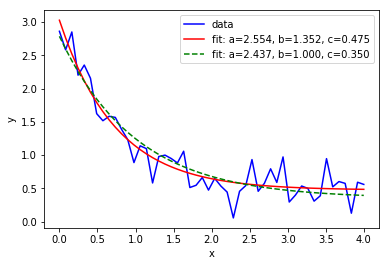

Parameter fits of optimized model:


array([2.43708905, 1.        , 0.35015434])

R-squared of fit:


0.8957084790510728

Parameter uncertainties (1 sigma):


array([0.12336385, 0.12952817, 0.07844143])

In [3]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata)
popt
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

print("Parameter fits of optimized model:")
display(popt)
print("R-squared of fit:")
residuals = ydata - func(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
display(r_squared)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr = np.sqrt(np.diag(pcov))
display(perr)


## The real deal

### Load data, take a peek

In [4]:
dielSulfonates_raw = pandas.read_csv('data/sulfonates/sulfonates_BD.csv')
dielSeaFlow_raw = pandas.read_csv('data/seaflow/seaflow_biomassDIEL_jorJamie.csv')

display(dielSulfonates_raw.head(n=10))
display(dielSeaFlow_raw.head(n=10))

,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26T17:11:00-0000,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26T17:11:00-0000,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26T17:11:00-0000,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283
3,7,1000,1,2015-07-26T20:25:00-0000,7.601564,3.198881e+06,315.924313,12.603545,4.005653,209.026833
4,7,1000,2,2015-07-26T20:25:00-0000,4.291812,5.744861e+06,771.503512,31.420815,3.718890,65.651715
5,7,1000,3,2015-07-26T20:25:00-0000,0.592208,4.729765e+06,1527.930893,19.561125,6.248778,51.148806
6,8,1400,1,2015-07-27T00:29:00-0000,7.195938,5.410413e+06,1761.605319,33.739859,4.320685,71.730329
7,8,1400,2,2015-07-27T00:29:00-0000,0.466945,1.021502e+07,5043.952082,55.227529,12.421041,94.619387
8,8,1400,3,2015-07-27T00:29:00-0000,6.103194,4.964977e+06,666.905509,45.784641,2.872352,114.770626
9,11,1800,1,2015-07-27T04:27:00-0000,2.901025,7.968625e+06,2311.339370,49.955310,2.753558,135.176525


,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-25T07:01:00-00:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-25T07:04:00-00:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-25T07:07:00-00:00,1.207168,10.731003,12.954125,1.078549
3,2015-07-25T07:10:00-00:00,1.088433,10.819991,11.776836,0.980529
4,2015-07-25T07:13:00-00:00,1.015561,9.844304,9.997491,0.832382
5,2015-07-25T07:16:00-00:00,1.181247,10.650057,12.580345,1.047428
6,2015-07-25T07:19:00-00:00,1.070121,10.080352,10.787198,0.898132
7,2015-07-25T07:22:00-00:00,0.976476,10.383692,10.139423,0.844199
8,2015-07-25T07:25:00-00:00,1.123217,9.155938,10.284105,0.856245
9,2015-07-25T07:28:00-00:00,1.038736,9.513941,9.882473,0.822806


### Do some data cleaning

In [5]:
dielSulfonates = dielSulfonates_raw.copy()
dielSeaFlow = dielSeaFlow_raw.copy()

# parse and convert dates, ensure all in HST, then store
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates_raw['Timestamp_bottle_closure_GMT_ISO8601'].apply(iso8601.parse_date))
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow_raw['Timestamp_ISO8601'].apply(iso8601.parse_date))
dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow['Timestamp_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

# take a look again at new objects
display(dielSeaFlow.head(n=3))
display(dielSulfonates.head(n=3))

,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-24 21:01:00-10:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-24 21:04:00-10:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-24 21:07:00-10:00,1.207168,10.731003,12.954125,1.078549


,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26 07:11:00-10:00,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26 07:11:00-10:00,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26 07:11:00-10:00,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283


### Initial analysis

#### Some initial plots since not all the compounds display diel periodicity

#### Sulfonate data: DHPS

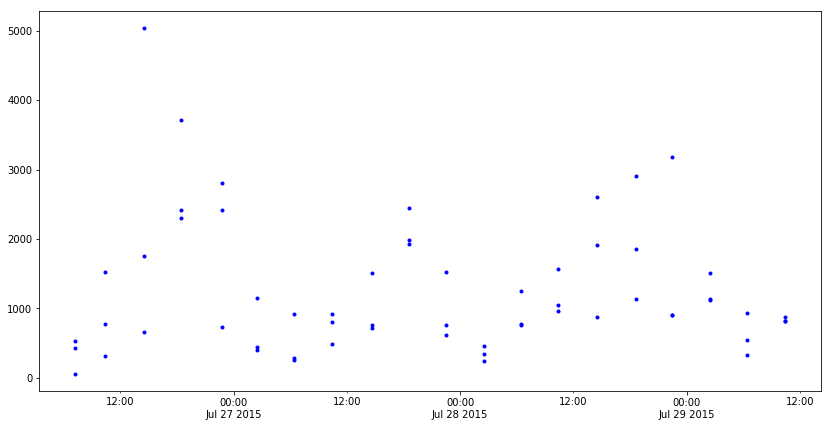

In [6]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['DHPS_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

#ax2 = ax1.twinx()
#ax2.plot(dielSeaFlow['Timestamp_ISO8601'],dielSeaFlow['Cbiomass_umol.L'], 'r-')

#ax2.set_ylim(0.4, 1.8)

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

#### Sulfonate data: Cysteic_Acid_pmol.L

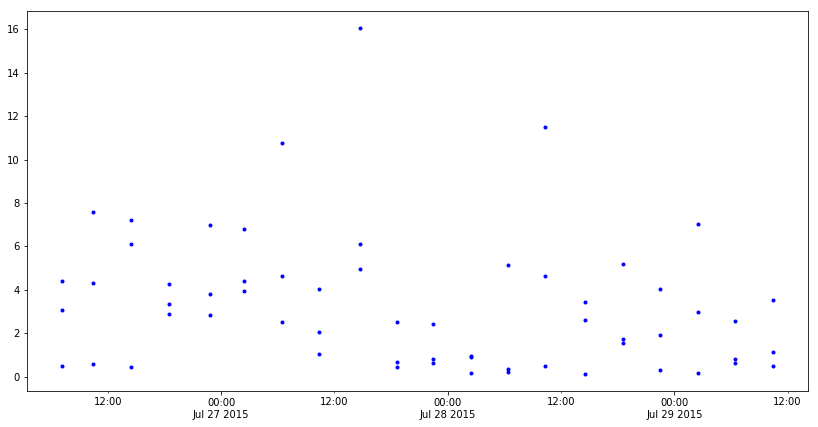

In [7]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['Cysteic_Acid_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

#### Sulfonate data: Cysteinolic_acid_PA.L

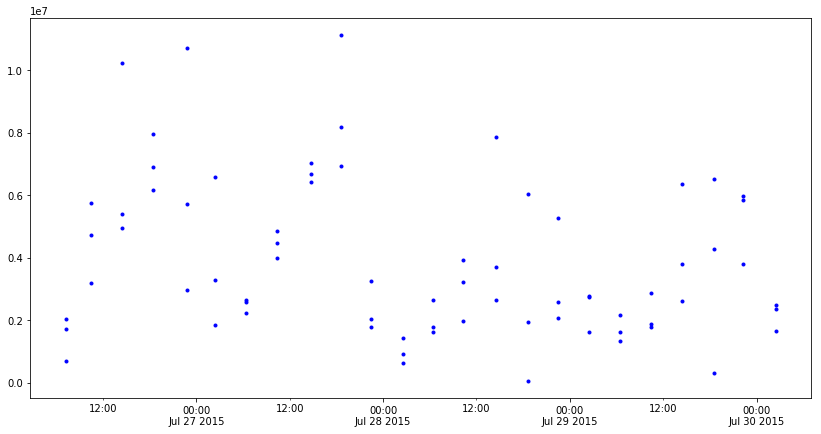

In [8]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['Cysteinolic_acid_PA.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

#### Sulfonate data: Isethionic_Acid_pmol.L

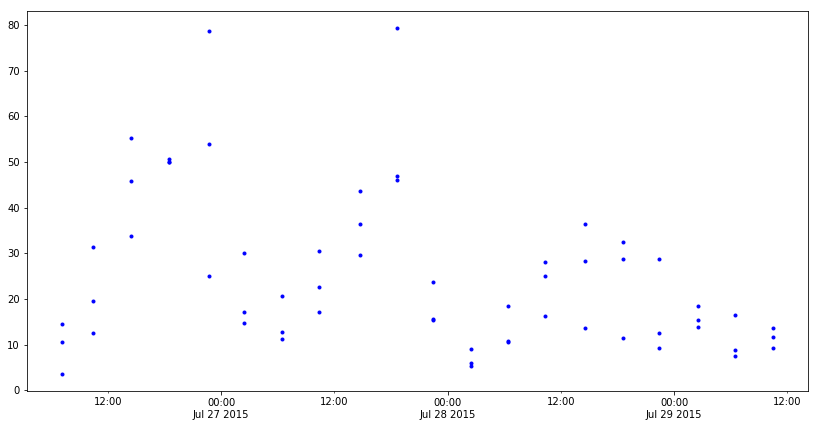

In [9]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['Isethionic_Acid_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

#### Sulfonate data: Sulfolactic_Acid_pmol.L

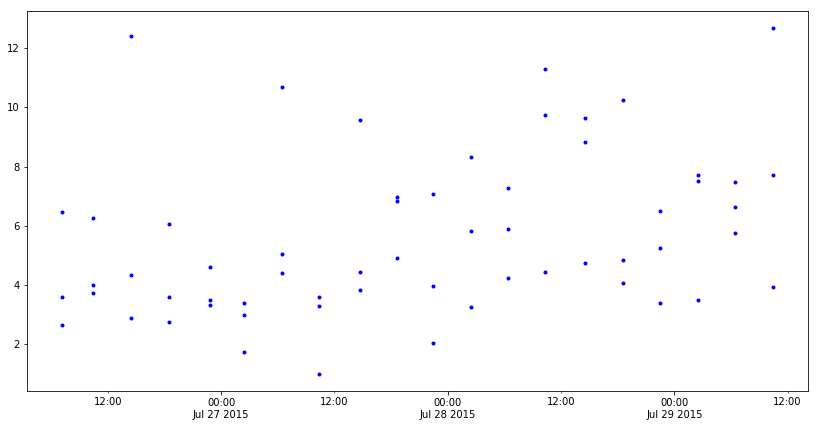

In [10]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['Sulfolactic_Acid_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

#### Sulfonate data: Taurine_pmol.L

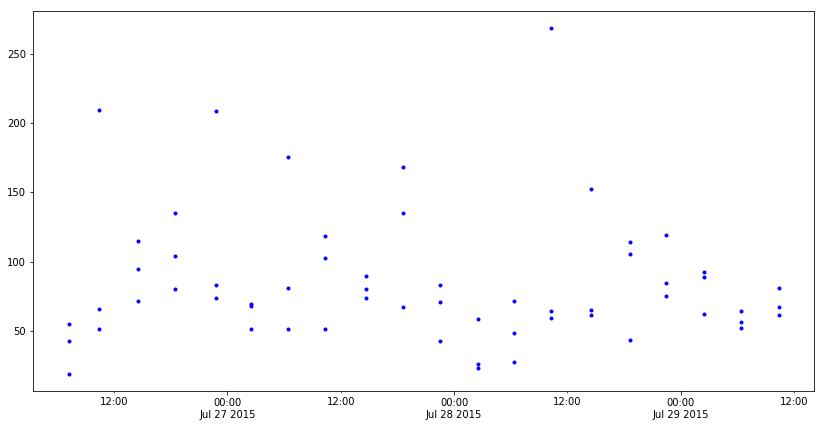

In [11]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['Taurine_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

It looks like only DHPS, cysteinolic acid, isethionic acid, and (to a much lesser extent) taurine have any promise as far as diel periodicity goes

### Now, onto the curve fitting 

#### First, definition of our functions

Case for three periods, where length of period is allowed to vary:

$$y = a\sin(\frac{2\pi}{b}x+c)+d\sin(\frac{2\pi}{e}x+f)+g\sin(\frac{2\pi}{h}x+i)+j+kx$$

Amplitudes: $a, d, g$

Period: $b, e, h$

Phase: $c, f, i$

$y$-offset: $j$

Linear trend term: $k$

In [12]:
# function where period is kept constant
def multWaves_func_samePer_3(x, a, b, c, d, e, f, g, h, i):
    return a * (np.sin(2 * np.pi / b * x + c )) + (
        d * (np.sin(2 * np.pi / b * x + e ))) + (
        f * (np.sin(2 * np.pi / b * x + g ))) + h + i * x
# a, d, f: amplitudes
# b: period
# c, e, g: phase
# h: y-offset
# i: slope of linear trend (if any)

# function where period is allowed to vary
def multWaves_func_varPer_3(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * np.sin(2 * np.pi / b * x + c ) + (
        d * np.sin(2 * np.pi / e * x + f )) + (
        g * np.sin(2 * np.pi / h * x + i )) + j + k * x
# a, d, g: amplitudes
# b, e, h: period
# c, f, i: phase
# j: y-offset
# k: slope of linear trend (if any)

Case for four periods, where length of period is allowed to vary:

$$y = a\sin(\frac{2\pi}{b}x+c)+d\sin(\frac{2\pi}{e}x+f)+g\sin(\frac{2\pi}{h}x+i)+j\sin(\frac{2\pi}{k}x+l)+m+nx$$

Amplitudes: $a, d, g, j$

Period: $b, e, h, k$

Phase: $c, f, i, l$

$y$-offset: $m$

Linear trend term: $n$

In [13]:
# function where period is allowed to vary
def multWaves_func_varPer_4(x, a, b, c, d, e, f, g, h, i, j, k, l, m, n):
    return a * np.sin(2 * np.pi / b * x + c ) + (
        d * np.sin(2 * np.pi / e * x + f )) + (
        g * np.sin(2 * np.pi / h * x + i )) + (
        j * np.sin(2 * np.pi / k * x + l )) + m + n * x
# a, d, g, j: amplitudes
# b, e, h, k: period
# c, f, i, l: phase
# m: y-offset
# n: slope of linear trend (if any)

# function where period is kept constant
def multWaves_func_samePer_4(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * (np.sin(2 * np.pi / b * x + c )) + (
        d * (np.sin(2 * np.pi / b * x + e ))) + (
        f * (np.sin(2 * np.pi / b * x + g ))) + (
        h * (np.sin(2 * np.pi / b * x + i ))) + j + k * x
# a, d, f, h: amplitudes
# b: period
# c, e, g, i: phase
# j: y-offset
# k: slope of linear trend (if any)

#### Sulfonate data: DHPS (three periods)

First, let's take a look at a quick plot again

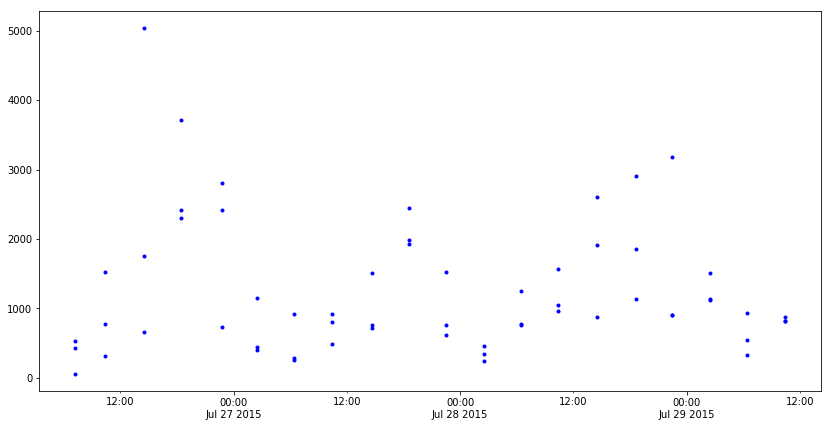

In [14]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['DHPS_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

#ax2 = ax1.twinx()
#ax2.plot(dielSeaFlow['Timestamp_ISO8601'],dielSeaFlow['Cbiomass_umol.L'], 'r-')

#ax2.set_ylim(0.4, 1.8)

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

Before curve fitting, have to excise some NaNs and convert the timestamp field to a different data type

In [15]:
# remove NaNs
TimestampDHPS_noNan = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]
ConcDHPS_noNan = dielSulfonates['DHPS_pmol.L'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]

# convert time object
print("Starting as:",type(TimestampDHPS_noNan[0]),",",TimestampDHPS_noNan.dtypes)
display(TimestampDHPS_noNan.head(n=3))

TimestampDHPS_secFromStart = TimestampDHPS_noNan-TimestampDHPS_noNan[0]

print("After converting:",type(TimestampDHPS_secFromStart[0]),",",TimestampDHPS_secFromStart.dtypes)
display(TimestampDHPS_secFromStart.head(n=20))

TimestampDHPS_secFromStart_alt = (
    TimestampDHPS_secFromStart.apply(
        lambda x: x.total_seconds()))

print("Or maybe just as second increments:")
display(TimestampDHPS_secFromStart_alt.head(n=20))

Starting as: <class 'pandas._libs.tslib.Timestamp'> , datetime64[ns, Pacific/Honolulu]


0   2015-07-26 07:11:00-10:00
1   2015-07-26 07:11:00-10:00
2   2015-07-26 07:11:00-10:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: datetime64[ns, Pacific/Honolulu]

After converting: <class 'pandas._libs.tslib.Timedelta'> , timedelta64[ns]


0    00:00:00
1    00:00:00
2    00:00:00
3    03:14:00
4    03:14:00
5    03:14:00
6    07:18:00
7    07:18:00
8    07:18:00
9    11:16:00
10   11:16:00
11   11:16:00
12   15:35:00
13   15:35:00
14   15:35:00
15   19:16:00
16   19:16:00
17   19:16:00
18   23:15:00
19   23:15:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: timedelta64[ns]

Or maybe just as second increments:


0         0.0
1         0.0
2         0.0
3     11640.0
4     11640.0
5     11640.0
6     26280.0
7     26280.0
8     26280.0
9     40560.0
10    40560.0
11    40560.0
12    56100.0
13    56100.0
14    56100.0
15    69360.0
16    69360.0
17    69360.0
18    83700.0
19    83700.0
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: float64

Actually do the fitting

In [16]:
# do the fitting, using the functions defined above
popt_samePer_DHPS, pcov_samePer_DHPS = curve_fit(multWaves_func_samePer_3, TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, bounds=(
    [-100000, 50000, -100000, -100000, -100000, -100000, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 15000, 15000, 15000, 15000, 15000])))
popt_varPer_DHPS, pcov_varPer_DHPS = curve_fit(multWaves_func_varPer_3, TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, bounds=(
    [-100000, 0, -100000, -100000, 0, -100000, -100000, 0, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 100000, 15000, 15000, 100000, 15000, 15000, 15000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd value) is kept constant:")
display(popt_samePer_DHPS)
print("R-squared of fit:")
residuals_samePer_DHPS = ConcDHPS_noNan - multWaves_func_samePer_3(TimestampDHPS_secFromStart_alt, *popt_samePer_DHPS)
ss_res_samePer_DHPS = np.sum(residuals_samePer_DHPS**2)
ss_tot_samePer_DHPS = np.sum((ConcDHPS_noNan-np.mean(ConcDHPS_noNan))**2)
r_squared_samePer_DHPS = 1 - (ss_res_samePer_DHPS / ss_tot_samePer_DHPS)
display(r_squared_samePer_DHPS)
# calculate the uncertainties in our coefficients
print("Parameter uncertainties (1 sigma):")
perr_samePer_DHPS = np.sqrt(np.diag(pcov_samePer_DHPS))
display(perr_samePer_DHPS)

print("Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:")
display(popt_varPer_DHPS)
print("R-squared of fit:")
residuals_varPer_DHPS = ConcDHPS_noNan - multWaves_func_varPer_3(TimestampDHPS_secFromStart_alt, *popt_varPer_DHPS)
ss_res_varPer_DHPS = np.sum(residuals_varPer_DHPS**2)
ss_tot_varPer_DHPS = np.sum((ConcDHPS_noNan-np.mean(ConcDHPS_noNan))**2)
r_squared_varPer_DHPS = 1 - (ss_res_varPer_DHPS / ss_tot_varPer_DHPS)
display(r_squared_varPer_DHPS)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer_DHPS = np.sqrt(np.diag(pcov_varPer_DHPS))
display(perr_varPer_DHPS)

# some basic hypothesis testing for significance

# define test statistics as popt_varPer_DHPS / perr_varPer_DHPS
DHPS_varPer_3_teststats = popt_varPer_DHPS / perr_varPer_DHPS
print("Test statistics:")
np.set_printoptions(suppress=True)
display(DHPS_varPer_3_teststats)

# calculate degrees of freedom, critical values
print("Degrees of freedom:")
DHPS_varPer_3_df = len(TimestampDHPS_secFromStart_alt) - len(popt_varPer_DHPS) - 1
display(DHPS_varPer_3_df)

print("Critical values:")
DHPS_varPer_3_crit = [-t.ppf(1-.05/2,DHPS_varPer_3_df), t.ppf(1-.05/2,DHPS_varPer_3_df)]
display(DHPS_varPer_3_crit)

# a, d, g: amplitudes
# b, e, h: period
# c, f, i: phase
# j: y-offset
# k: slope of linear trend (if any)


Parameter fits for model where length of period (2nd value) is kept constant:


array([-3.30122369e+04,  8.66480866e+04, -4.01303186e+04, -3.30105357e+04,
       -4.01282511e+04, -3.30364811e+04, -4.01198715e+04,  1.36253503e+03,
       -3.53984700e-04])

R-squared of fit:


0.3883210579251529

Parameter uncertainties (1 sigma):


array([2.18748060e+10, 2.92591167e+03, 1.46580160e+10, 3.57914871e+10,
       1.44621378e+10, 2.06574497e+10, 1.48871028e+10, 2.13523625e+02,
       1.37331660e-03])

Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:


array([-3.21560273e+04,  8.13034806e+04, -4.13139673e+04, -3.26143972e+04,
        8.13976898e+04, -4.13160534e+04, -3.24660856e+04,  8.15025846e+04,
       -4.12490076e+04,  1.47429795e+03, -1.12153956e-03])

R-squared of fit:


0.4397489163179775

Parameter uncertainties (1 sigma):


array([1.39656969e+09, 1.89705058e+06, 2.16525623e+04, 9.90926567e+08,
       4.99776640e+06, 7.35750057e+04, 1.77612940e+09, 3.20306323e+06,
       1.76096632e+04, 2.25904299e+02, 1.49056839e-03])

Test statistics:


array([-0.00002303,  0.04285783, -1.90804057, -0.00003291,  0.01628681,
       -0.56155012, -0.00001828,  0.0254452 , -2.34240753,  6.5262058 ,
       -0.75242409])

Degrees of freedom:


48

Critical values:


[-2.0106347546964454, 2.0106347546964454]

Now, let's take a look at a plot of the data, with the curve fit (varying period length allowed)

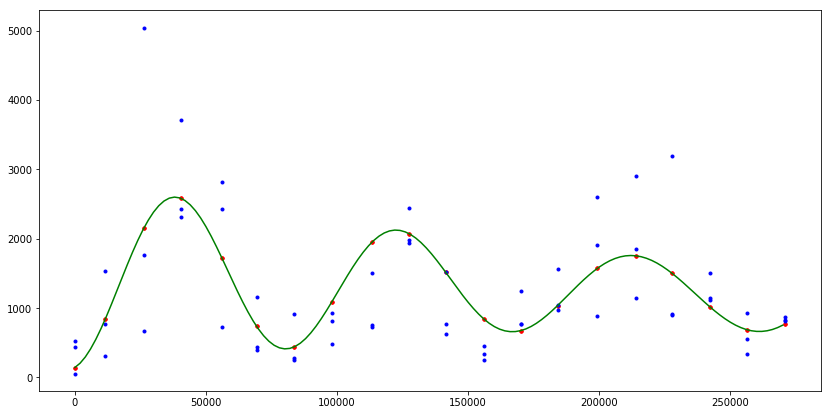

In [17]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampDHPS_secFromStart_alt, multWaves_func_varPer_3(TimestampDHPS_secFromStart_alt, *popt_varPer_DHPS), 'r.')
plt.plot(TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_varPer_DHPS), 'g-')

A plot of the data, with the curve fit (length of period required to be constant)

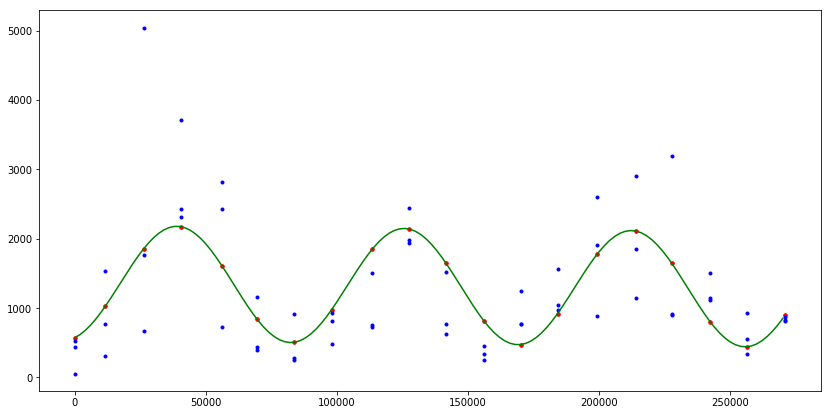

In [18]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampDHPS_secFromStart_alt, multWaves_func_samePer_3(TimestampDHPS_secFromStart_alt, *popt_samePer_DHPS), 'r.')
plt.plot(TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_samePer_DHPS), 'g-')

Look at the two together

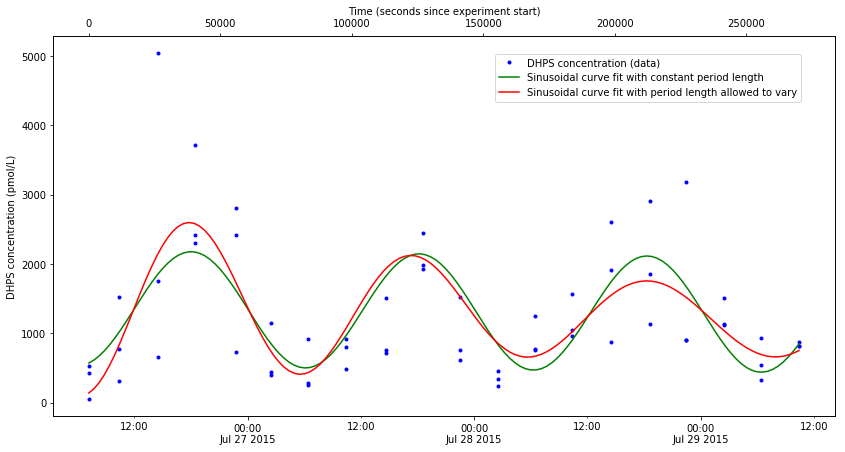

In [29]:
# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(TimestampDHPS_noNan,ConcDHPS_noNan, 'b.', label = 'DHPS concentration (data)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('DHPS concentration (pmol/L)')

ax2 = ax1.twiny()
ax2.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_samePer_DHPS), 'g-', label = 'Sinusoidal curve fit with constant period length')
ax2.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_varPer_DHPS), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


#### Sulfonate data: Cysteinolic acid (four periods)

Parameter fits for model where length of period (2nd, 5th, 8th, 11th values) is allowed to vary:


array([ 5.63161946e+06,  7.99999966e+05, -2.99849706e+05,  1.43176884e+07,
        7.68344903e+04, -3.00175547e+05,  6.23200914e+08,  7.54428252e+04,
       -2.99998713e+05,  6.27737410e+08,  7.54537929e+04, -3.00001872e+05,
        5.31987951e+06,  1.20318536e+01])

R-squared of fit:


0.44009704142002126

Parameter uncertainties (1 sigma):


array([6.48047056e+07, 4.18656017e+06, 4.09001788e+00, 2.16621814e+09,
       1.06343195e+05, 2.76544432e+01, 1.58426254e+09, 4.66324216e+04,
       1.98248368e+02, 1.58361539e+09, 4.72533592e+04, 1.99491631e+02,
       7.15992072e+06, 2.71342167e+02])

Test statistics:


array([     0.0869014 ,      0.19108766, -73312.56593986,      0.00660953,
            0.72251441, -10854.51424893,      0.39336972,      1.61781916,
        -1513.24682451,      0.39639512,      1.59679215,  -1503.83186615,
            0.74300816,      0.044342  ])

Degrees of freedom:


57

Critical values:


[-1.6720288881322787, 1.6720288881322787]

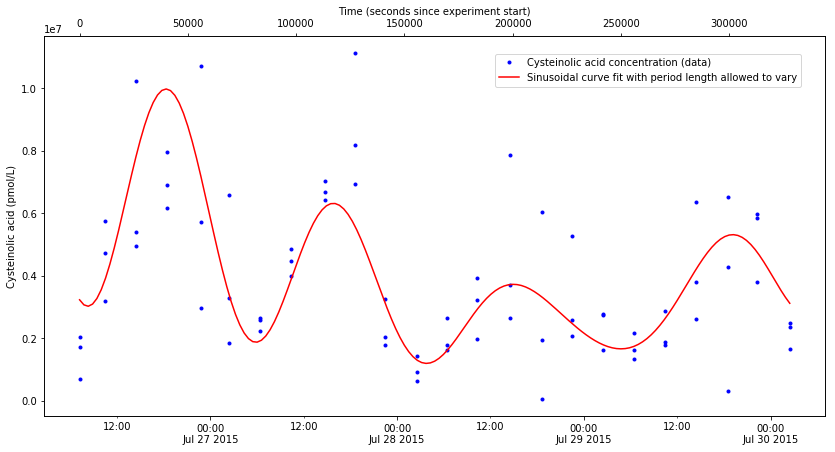

In [76]:
# remove NaNs
TimestampCysteinolic_noNan = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['Cysteinolic_acid_PA.L'])]
ConcCysteinolic_noNan = dielSulfonates['Cysteinolic_acid_PA.L'][~np.isnan(dielSulfonates['Cysteinolic_acid_PA.L'])]

# create time objects
TimestampCysteinolic_secFromStart = TimestampCysteinolic_noNan-TimestampCysteinolic_noNan[0]

TimestampCysteinolic_secFromStart_alt = (
    TimestampCysteinolic_secFromStart.apply(
        lambda x: x.total_seconds()))

# do the fitting, with function defined above
popt_varPer_Cysteinolic, pcov_varPer_Cysteinolic = curve_fit(multWaves_func_varPer_4, TimestampCysteinolic_secFromStart_alt, ConcCysteinolic_noNan, bounds=(
    [100000, 50000, -1000000, 100000, 95000, -1000000, 100000, 50000, -1000000, 100000, 50000, -1000000, -1000000, -1000000], (
        [300000000, 1500000, 200000, 300000000, 150000, 200000, 300000000, 150000, 200000, 300000000, 150000, 200000, 200000, 200000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd, 5th, 8th, 11th values) is allowed to vary:")
display(popt_varPer_Cysteinolic)
print("R-squared of fit:")
residuals_varPer_Cysteinolic = ConcCysteinolic_noNan - multWaves_func_varPer_4(TimestampCysteinolic_secFromStart_alt, *popt_varPer_Cysteinolic)
ss_res_varPer_Cysteinolic = np.sum(residuals_varPer_Cysteinolic**2)
ss_tot_varPer_Cysteinolic = np.sum((ConcCysteinolic_noNan-np.mean(ConcCysteinolic_noNan))**2)
r_squared_varPer_Cysteinolic = 1 - (ss_res_varPer_Cysteinolic / ss_tot_varPer_Cysteinolic)
display(r_squared_varPer_Cysteinolic)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer_Cysteinolic = np.sqrt(np.diag(pcov_varPer_Cysteinolic))
display(perr_varPer_Cysteinolic)

# some basic hypothesis testing for significance

# define test statistics as popt_varPer_DHPS / perr_varPer_DHPS
Cysteinolic_varPer_4_teststats = popt_varPer_Cysteinolic / perr_varPer_Cysteinolic
print("Test statistics:")
np.set_printoptions(suppress=True)
display(Cysteinolic_varPer_4_teststats)

# calculate degrees of freedom, critical values
print("Degrees of freedom:")
Cysteinolic_varPer_4_df = len(TimestampCysteinolic_secFromStart_alt) - len(popt_varPer_Cysteinolic) - 1
display(Cysteinolic_varPer_4_df)

print("Critical values at alpha = 0.1:")
Cysteinolic_varPer_4_crit = [-t.ppf(1-.1/2,Cysteinolic_varPer_4_df), t.ppf(1-.1/2,Cysteinolic_varPer_4_df)]
display(Cysteinolic_varPer_4_crit)

print("Critical values at alpha = 0.05:")
Cysteinolic_varPer_4_crit = [-t.ppf(1-.05/2,Cysteinolic_varPer_4_df), t.ppf(1-.05/2,Cysteinolic_varPer_4_df)]
display(Cysteinolic_varPer_4_crit)

# make plot

# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(TimestampCysteinolic_noNan,ConcCysteinolic_noNan, 'b.', label = 'Cysteinolic acid concentration (data)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Cysteinolic acid (pmol/L)')

ax2 = ax1.twiny()
ax2.plot(pandas.Series(list(range(0, int(TimestampCysteinolic_secFromStart_alt[len(TimestampCysteinolic_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
   pandas.Series(list(range(0, int(TimestampCysteinolic_secFromStart_alt[len(TimestampCysteinolic_secFromStart_alt)-1]), 2000))), *popt_varPer_Cysteinolic), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


#### Sulfonate data: Isethionic acid (three periods)

Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:


array([    -2.56069378, 199999.9999983 ,  14579.15248723,     13.62467832,
        85968.91695113,  14606.89020605,      9.29405903,  70942.59605321,
        14624.99450507,     37.80955554,     -0.0000865 ])

R-squared of fit:


0.6802018336384881

Parameter uncertainties (1 sigma):


array([     4.65462338, 303058.1947764 ,      6.21223335,      3.35362163,
         4236.24645709,      0.67859456,      4.84474071,   7569.83527811,
            1.22875414,     13.3823088 ,      0.00009943])

Test statistics:


array([   -0.55013984,     0.65993926,  2346.84559555,     4.06267606,
          20.29365331, 21525.20977108,     1.91838111,     9.37174898,
       11902.2952318 ,     2.82533874,    -0.87000464])

Degrees of freedom:


48

Critical values:


[-2.0106347546964454, 2.0106347546964454]

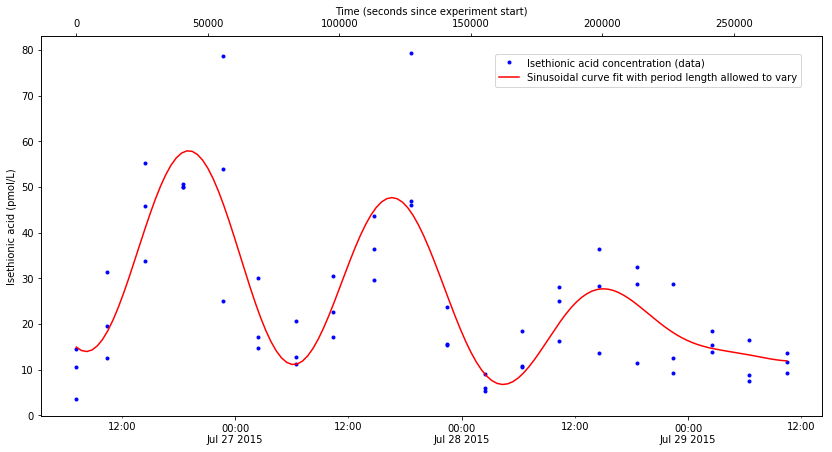

In [41]:
# remove NaNs
TimestampIsethionic_noNan = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['Isethionic_Acid_pmol.L'])]
ConcIsethionic_noNan = dielSulfonates['Isethionic_Acid_pmol.L'][~np.isnan(dielSulfonates['Isethionic_Acid_pmol.L'])]

# create time objects
TimestampIsethionic_secFromStart = TimestampIsethionic_noNan-TimestampIsethionic_noNan[0]

TimestampIsethionic_secFromStart_alt = (
    TimestampIsethionic_secFromStart.apply(
        lambda x: x.total_seconds()))

# do the fitting, with function defined above
popt_varPer_Isethionic, pcov_varPer_Isethionic = curve_fit(multWaves_func_varPer_3, TimestampIsethionic_secFromStart_alt, ConcIsethionic_noNan, bounds=(
    [-10000, 40000, -100000, -10000, 40000, -100000, -10000, 40000, -100000, -100000, -100000], (
        [15000, 200000, 150000, 15000, 200000, 150000, 15000, 200000, 150000, 150000, 150000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:")
display(popt_varPer_Isethionic)
print("R-squared of fit:")
residuals_varPer_Isethionic = ConcIsethionic_noNan - multWaves_func_varPer_3(TimestampIsethionic_secFromStart_alt, *popt_varPer_Isethionic)
ss_res_varPer_Isethionic = np.sum(residuals_varPer_Isethionic**2)
ss_tot_varPer_Isethionic = np.sum((ConcIsethionic_noNan-np.mean(ConcIsethionic_noNan))**2)
r_squared_varPer_Isethionic = 1 - (ss_res_varPer_Isethionic / ss_tot_varPer_Isethionic)
display(r_squared_varPer_Isethionic)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer_Isethionic = np.sqrt(np.diag(pcov_varPer_Isethionic))
display(perr_varPer_Isethionic)

# some basic hypothesis testing for significance

# define test statistics as popt_varPer_DHPS / perr_varPer_DHPS
Isethionic_varPer_3_teststats = popt_varPer_Isethionic / perr_varPer_Isethionic
print("Test statistics:")
np.set_printoptions(suppress=True)
display(Isethionic_varPer_3_teststats)

# calculate degrees of freedom, critical values
print("Degrees of freedom:")
Isethionic_varPer_3_df = len(TimestampIsethionic_secFromStart_alt) - len(popt_varPer_Isethionic) - 1
display(Isethionic_varPer_3_df)

print("Critical values:")
Isethionic_varPer_3_crit = [-t.ppf(1-.05/2,Isethionic_varPer_3_df), t.ppf(1-.05/2,Isethionic_varPer_3_df)]
display(Isethionic_varPer_3_crit)

# make plot

# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(TimestampIsethionic_noNan,ConcIsethionic_noNan, 'b.', label = 'Isethionic acid concentration (data)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Isethionic acid (pmol/L)')

ax2 = ax1.twiny()
ax2.plot(pandas.Series(list(range(0, int(TimestampIsethionic_secFromStart_alt[len(TimestampIsethionic_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampIsethionic_secFromStart_alt[len(TimestampIsethionic_secFromStart_alt)-1]), 2000))), *popt_varPer_Isethionic), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


#### Sulfonate data: Taurine (three periods)

The taurine plot still looks pretty iffy... doubt there's much legit diel periodicity going on here

In [42]:
# remove NaNs
TimestampTaurine_noNan = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['Taurine_pmol.L'])]
ConcTaurine_noNan = dielSulfonates['Taurine_pmol.L'][~np.isnan(dielSulfonates['Taurine_pmol.L'])]

# create time objects
TimestampTaurine_secFromStart = TimestampTaurine_noNan-TimestampTaurine_noNan[0]

TimestampTaurine_secFromStart_alt = (
    TimestampTaurine_secFromStart.apply(
        lambda x: x.total_seconds()))

# do the fitting, with function defined above
popt_varPer_Taurine, pcov_varPer_Taurine = curve_fit(multWaves_func_varPer_3, TimestampTaurine_secFromStart_alt, ConcTaurine_noNan, bounds=(
    [-10000, 40000, -100000, -10000, 40000, -100000, -10000, 40000, -100000, -100000, -100000], (
        [15000, 200000, 150000, 15000, 200000, 150000, 15000, 200000, 150000, 150000, 150000])))
#max_nfev = 10000

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:")
display(popt_varPer_Taurine)
print("R-squared of fit:")
residuals_varPer_Taurine = ConcTaurine_noNan - multWaves_func_varPer_3(TimestampTaurine_secFromStart_alt, *popt_varPer_Taurine)
ss_res_varPer_Taurine = np.sum(residuals_varPer_Taurine**2)
ss_tot_varPer_Taurine = np.sum((ConcTaurine_noNan-np.mean(ConcTaurine_noNan))**2)
r_squared_varPer_Taurine = 1 - (ss_res_varPer_Taurine / ss_tot_varPer_Taurine)
display(r_squared_varPer_Taurine)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer_Taurine = np.sqrt(np.diag(pcov_varPer_Taurine))
display(perr_varPer_Taurine)

# make plot

# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(TimestampTaurine_noNan,ConcTaurine_noNan, 'b.', label = 'Taurine concentration (data)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Taurine (pmol/L)')

ax2 = ax1.twiny()
ax2.plot(pandas.Series(list(range(0, int(TimestampTaurine_secFromStart_alt[len(TimestampTaurine_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampTaurine_secFromStart_alt[len(TimestampTaurine_secFromStart_alt)-1]), 2000))), *popt_varPer_Taurine), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

#### Seaflow data

We'll truncate the data so the time domain (at least lower bound) is the same as the sulfur compound concentration data

In [ ]:
# truncate data to same datetime range as the sulfur compound concentrations
dielSeaFlow.trunc = dielSeaFlow[dielSeaFlow['Timestamp_ISO8601']>=min(TimestampDHPS_noNan)]
#dielSeaFlow.trunc = dielSeaFlow.trunc[dielSeaFlow.trunc['Timestamp_ISO8601']<=max(TimestampDHPS_noNan)]

# quick look at a plot
# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSeaFlow.trunc['Timestamp_ISO8601'],dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

It's evident that the phase of the Seaflow data isn't the same as the sulfur compound data. We'll still try to fit s curve to it.

In [23]:
# convert time object
print("Starting as:",type(dielSeaFlow.trunc['Timestamp_ISO8601'][0]),",",dielSeaFlow.trunc['Timestamp_ISO8601'].dtypes)
display(dielSeaFlow.trunc['Timestamp_ISO8601'].head(n=3))

TimestampSeaflow_secFromStart = dielSeaFlow.trunc['Timestamp_ISO8601']-dielSeaFlow.trunc['Timestamp_ISO8601'][0]
TimestampSeaflow_secFromStart_alt = (
    TimestampSeaflow_secFromStart.apply(
        lambda x: x.total_seconds()))

print("As second increments:")
display(TimestampSeaflow_secFromStart_alt.head(n=20))

AttributeError: 'DataFrame' object has no attribute 'trunc'

Do the fitting for the Seaflow data; will use four periods instead of three

In [ ]:
# do the fitting, with function defined above
popt_samePer_SeaFlow, pcov_samePer_SeaFlow = curve_fit(multWaves_func_samePer_4, TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], bounds=(
    [-100000, 50000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000], (
        [150000, 100000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 15000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd value) is kept constant:")
display(popt_samePer_SeaFlow)
print("R-squared of fit:")
residuals_samePer_SeaFlow = dielSeaFlow.trunc['Sum of Cbiomass_ug.L'] - multWaves_func_samePer_4(TimestampSeaflow_secFromStart_alt, *popt_samePer_SeaFlow)
ss_res_samePer_SeaFlow = np.sum(residuals_samePer_SeaFlow**2)
ss_tot_samePer_SeaFlow = np.sum((dielSeaFlow.trunc['Sum of Cbiomass_ug.L']-np.mean(dielSeaFlow.trunc['Sum of Cbiomass_ug.L']))**2)
r_squared_samePer_SeaFlow = 1 - (ss_res_samePer_SeaFlow / ss_tot_samePer_SeaFlow)
display(r_squared_samePer_SeaFlow)
# calculate the uncertainties in our coefficients
print("Parameter uncertainties (1 sigma):")
perr_samePer_SeaFlow = np.sqrt(np.diag(pcov_samePer_SeaFlow))
display(perr_samePer_SeaFlow)

Now, let's take a look at a plot of the data, with the curve fit (period length fixed)

In [ ]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_samePer_4(TimestampSeaflow_secFromStart_alt, *popt_samePer_SeaFlow), 'r.')
plt.plot(TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_4(
   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_samePer_SeaFlow), 'g-')

In [ ]:
# do the fitting, with function defined above
popt_varPer_SeaFlow, pcov_varPer_SeaFlow = curve_fit(multWaves_func_varPer_4, TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Cbiomass_umol.L'], bounds=(
    [-100000, 50000, -1000000, -100000, 95000, -1000000, -100000, 50000, -1000000, -100000, 50000, -1000000, -1000000, -1000000], (
        [200000, 1500000, 200000, 200000, 150000, 200000, 200000, 150000, 200000, 200000, 150000, 200000, 200000, 200000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd, 5th, 8th, 11th values) is allowed to vary:")
display(popt_varPer_SeaFlow)
print("R-squared of fit:")
residuals_varPer_SeaFlow = dielSeaFlow.trunc['Cbiomass_umol.L'] - multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer_SeaFlow)
ss_res_varPer_SeaFlow = np.sum(residuals_varPer_SeaFlow**2)
ss_tot_varPer_SeaFlow = np.sum((dielSeaFlow.trunc['Cbiomass_umol.L']-np.mean(dielSeaFlow.trunc['Cbiomass_umol.L']))**2)
r_squared_varPer_SeaFlow = 1 - (ss_res_varPer_SeaFlow / ss_tot_varPer_SeaFlow)
display(r_squared_varPer_SeaFlow)

# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer_SeaFlow = np.sqrt(np.diag(pcov_varPer_SeaFlow))
display(perr_varPer_SeaFlow)

Now, let's take a look at some quick significance tests for various model parameters. Will use a series of two-tailed t-tests with alpha = 0.05.  

In [ ]:
# define test statistics as popt_varPer_SeaFlow / perr_varPer_SeaFlow
SeaFlow_varPer_4_teststats = popt_varPer_SeaFlow / perr_varPer_SeaFlow
print("Test statistics:")
np.set_printoptions(suppress=True)
display(SeaFlow_varPer_4_teststats)

# calculate degrees of freedom, critical values
print("Degrees of freedom:")
SeaFlow_varPer_4_df = len(TimestampSeaflow_secFromStart_alt) - len(popt_varPer_SeaFlow) - 1
display(SeaFlow_varPer_4_df)

print("Critical values:")
SeaFlow_varPer_4_crit = [-t.ppf(1-.05/2,SeaFlow_varPer_4_df), t.ppf(1-.05/2,SeaFlow_varPer_4_df)]
display(SeaFlow_varPer_4_crit)

We conclude that we cannot reject any model parameters at 0.05 since all the test statistics lie outside the range defined by the critical values.

Now, let's take a look at a plot of the data, with the curve fit (varying period length allowed)

In [ ]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer_SeaFlow), 'r.')
plt.plot(TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Cbiomass_umol.L'], 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_varPer_SeaFlow), 'g-')

Plot of the variable-period fit to the Seaflow data

In [ ]:
# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSeaFlow.trunc['Timestamp_ISO8601'],dielSeaFlow.trunc['Cbiomass_umol.L'], 'b.', label = 'SeaFlow biomass (umol/L)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('SeaFlow biomass (umol/L)')

ax2 = ax1.twiny()
#ax2.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
#   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_samePer), 'g-', label = 'Sinusoidal curve fit with constant period length')
#ax2.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
#   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_varPer), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
ax2.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer_SeaFlow), 'r-')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


### Some better looking plots

#### Seaflow data and some of the sulfonate species together

In [ ]:
# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 18))

# plot SeaFlow data

ax1 = fig.add_subplot(511)
ax1.plot(dielSeaFlow.trunc['Timestamp_ISO8601'],dielSeaFlow.trunc['Cbiomass_umol.L'], 'b.', label = 'SeaFlow biomass (umol/L)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('SeaFlow biomass (umol/L)')
ax1.margins(0)
plt.annotate('r$^2$ = '+str(round(r_squared_varPer_SeaFlow,2)), xy=(0.015, 0.9), xycoords='axes fraction')
plt.annotate('All model parameters significant at p $\leq$ 0.05', xy=(0.015, 0.8), xycoords='axes fraction')

ax2 = ax1.twiny()
ax2.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer_SeaFlow), 'r-')
plt.xlabel('Time (seconds since experiment start)')
ax2.margins(0)


# plot cysteinolic acid data

ax3 = fig.add_subplot(512)
ax3.plot(TimestampCysteinolic_noNan,ConcCysteinolic_noNan, 'b.', label = 'Cysteinolic acid concentration (data)')
ax3.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax3.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax3.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax3.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax3.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Cysteinolic acid (pmol/L)')
ax3.margins(0)
plt.annotate('r$^2$ = '+str(round(r_squared_varPer_Cysteinolic,2)), xy=(0.015, 0.9), xycoords='axes fraction')
plt.annotate('No model parameters significant at p $\leq$ 0.05', xy=(0.015, 0.8), xycoords='axes fraction')

ax4 = ax3.twiny()
ax4.plot(pandas.Series(list(range(0, int(TimestampCysteinolic_secFromStart_alt[len(TimestampCysteinolic_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
   pandas.Series(list(range(0, int(TimestampCysteinolic_secFromStart_alt[len(TimestampCysteinolic_secFromStart_alt)-1]), 2000))), *popt_varPer_Cysteinolic), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
ax4.xaxis.set_visible(False)
ax4.margins(0)

# plot isethionic acid data

# get a relative x-axis length so we know how long to make the secondary x axis
rel_xaxlength = (max(dielSeaFlow.trunc['Timestamp_ISO8601'])-min(dielSeaFlow.trunc['Timestamp_ISO8601']))/(
    max(TimestampIsethionic_noNan)-min(TimestampIsethionic_noNan))

ax5 = fig.add_subplot(513, sharex = ax3)
ax5.plot(TimestampIsethionic_noNan,ConcIsethionic_noNan, 'b.', label = 'Isethionic acid concentration (data)')
ax5.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax5.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax5.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax5.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax5.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Isethionic acid (pmol/L)')
ax5.margins(0)
plt.annotate('r$^2$ = '+str(round(r_squared_varPer_Isethionic,2)), xy=(0.015, 0.9), xycoords='axes fraction')
plt.annotate('No model parameters significant at p $\leq$ 0.05', xy=(0.015, 0.8), xycoords='axes fraction')

ax6 = ax5.twiny()
ax6.plot(pandas.Series(list(range(0, int(TimestampIsethionic_secFromStart_alt[len(TimestampIsethionic_secFromStart_alt)-1]), 2000))),
         multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampIsethionic_secFromStart_alt[len(TimestampIsethionic_secFromStart_alt)-1]), 2000))), *popt_varPer_Isethionic),
         'r-',
         label = 'Sinusoidal curve fit with period length allowed to vary')
ax6.set_xlim(0,max(pandas.Series(list(range(0, int(TimestampIsethionic_secFromStart_alt[len(TimestampIsethionic_secFromStart_alt)-1]), 2000))))*rel_xaxlength)
ax6.xaxis.set_visible(False)
ax6.margins(0)

# plot DHPS data

# get a relative x-axis length so we know how long to make the secondary x axis
rel_xaxlength = (max(dielSeaFlow.trunc['Timestamp_ISO8601'])-min(dielSeaFlow.trunc['Timestamp_ISO8601']))/(
    max(TimestampDHPS_noNan)-min(TimestampDHPS_noNan))

ax7 = fig.add_subplot(514, sharex = ax3)
ax7.plot(TimestampDHPS_noNan,ConcDHPS_noNan, 'b.', label = 'DHPS (data)')
ax7.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax7.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax7.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax7.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax7.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('DHPS (pmol/L)')
ax7.margins(0)
plt.annotate('r$^2$ = '+str(round(r_squared_varPer_DHPS,2)), xy=(0.015, 0.9), xycoords='axes fraction')

ax8 = ax7.twiny()
ax8.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))),
         multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_varPer_DHPS),
         'r-',
         label = 'Sinusoidal curve fit with period length allowed to vary')
ax8.set_xlim(0,max(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))))*rel_xaxlength)
ax8.xaxis.set_visible(False)
ax8.margins(0)

# plot taurine data

# get a relative x-axis length so we know how long to make the secondary x axis
rel_xaxlength = (max(dielSeaFlow.trunc['Timestamp_ISO8601'])-min(dielSeaFlow.trunc['Timestamp_ISO8601']))/(
    max(TimestampTaurine_noNan)-min(TimestampTaurine_noNan))

ax9 = fig.add_subplot(515, sharex = ax3)
ax9.plot(TimestampTaurine_noNan,ConcTaurine_noNan, 'b.', label = 'Taurine (data)')
ax9.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax9.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax9.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax9.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax9.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('Taurine (pmol/L)')
ax9.margins(0)
plt.annotate('r$^2$ = '+str(round(r_squared_varPer_Taurine,2)), xy=(0.015, 0.9), xycoords='axes fraction')

ax10 = ax9.twiny()
ax10.plot(pandas.Series(list(range(0, int(TimestampTaurine_secFromStart_alt[len(TimestampTaurine_secFromStart_alt)-1]), 2000))),
         multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampTaurine_secFromStart_alt[len(TimestampTaurine_secFromStart_alt)-1]), 2000))), *popt_varPer_Taurine),
         'r-',
         label = 'Sinusoidal curve fit with period length allowed to vary')
ax10.set_xlim(0,max(pandas.Series(list(range(0, int(TimestampTaurine_secFromStart_alt[len(TimestampTaurine_secFromStart_alt)-1]), 2000))))*rel_xaxlength)
ax10.xaxis.set_visible(False)
ax10.margins(0)


# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

In [ ]:
### Generate some 

### Some suggestions from presentation to lab on 9 May

- adaptive regression
- data perhaps too sparse for FFT
- JTK cycle to validate sinusoidal behavior?

### Some maxima/minima and amplitude-change calculations